# Reference Generation Task - Rich Embedding Analysis

This notebook analyzes a high dimensional embedding based on sentence transformers for the reference generation task, producing visualizations of how LLM-based union-style and intersection-style aggregation transform embeddungs. We consider embeddings of outputs from directly prompting an LLM with different prompts and embeddings from aggregating these outputs. We then visualize these embeddings by providing the following:
1. Pairwise L2 distance heatmap
2. Projection onto top 2 task-specific directions
3. Projection onto top 3 task-specific directions

## Setup

In [15]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from sentence_transformers import SentenceTransformer
from openai import OpenAI
from getpass import getpass

# Plot styling
sns.set_style('whitegrid')
sns.set_context('talk')  # larger base font sizes
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 20,          # default text
    'axes.titlesize': 24,     # axes titles
    'axes.labelsize': 20,     # x and y labels
    'xtick.labelsize': 18,    # x tick labels
    'ytick.labelsize': 18,    # y tick labels
    'legend.fontsize': 18     # legend
})

## Generate Papers Outputs

This section generates the component outputs (from 5 different perspective prompts) and two aggregated outputs (union and intersection style).

In [16]:
# Initialize OpenAI client
api_key = getpass("Enter your OpenAI API key: ")
client = OpenAI(api_key=api_key)
print("OpenAI client initialized")

OpenAI client initialized


In [17]:
# Define the 5 component prompts (different perspectives on influential LLM papers)
papers_prompts = [
    "From a machine learning theory perspective, list 10 influential papers that have shaped our current understanding of large language models.",
    
    "From the perspective of natural language processing and computational linguistics, list 10 key research papers that have been most influential in the development of modern large language models.",
    
    "From a cognitive science and psycholinguistics standpoint, list 10 important papers that inform our understanding of how large language models represent, process, or acquire linguistic and conceptual structure.",
    
    "From the standpoint of AI alignment and human-AI interaction, list 10 important papers that have shaped how large language models are aligned, instructed, or trained with feedback.",
    
    "From a multi-agent and game-theoretic perspective, list 10 influential papers that contribute to the development or understanding of large language models"
]

# Aggregation prompts
papers_union_prompt = """Each of the following lists contains influential papers on large language models in specializing in different areas: machine learning theory, natural language processing, computational linguistics, AI alignment, human-AI interaction, and multi-agent systems. Based on these lists, generate a new list of 10 papers that reflects the union of their themes and coverage. Your list should be freshly generated (not a literal set union), but it should include papers that plausibly come from any of the provided lists, covering as much of the combined topical space as possible."""

papers_intersection_prompt = """Each of the following lists contains influential papers on large language models in specializing in different areas: machine learning theory, natural language processing, computational linguistics, AI alignment, human-AI interaction, and multi-agent systems. Based on these lists, generate a new list of 10 papers that reflects their intersection. That is, papers belonging to many of these areas of specialization. Your list should be freshly generated (not a literal intersection), selecting papers that could plausibly appear in all of the lists. If the literal intersection is empty, still generate the best possible list of papers that are central, broadly relevant, and thematically compatible with all lists"""

print(f"Defined {len(papers_prompts)} component prompts")
print("Defined union and intersection aggregation prompts")

Defined 5 component prompts
Defined union and intersection aggregation prompts


In [ ]:
def generate_papers_outputs(
    prompts,
    union_prompt,
    intersection_prompt,
    client,
    model="gpt-4o-mini-2024-07-18",
    temperature=1.0,
    max_tokens=1024,
    save_path="papers_custom_outputs.json"
):
    """
    Generate component outputs for each prompt, then generate union and intersection aggregations.
    """
    def send_prompt(prompt_text):
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt_text}],
            max_completion_tokens=max_tokens,
            temperature=temperature
        )
        return response.choices[0].message.content
    
    def build_aggregation_prompt(outputs, base_prompt):
        sections = "\n\n".join(
            f"List of Papers {idx+1}:\n{output}" for idx, output in enumerate(outputs)
        )
        return base_prompt + "\n\n" + sections
    
    # Generate component outputs
    component_outputs = []
    for idx, prompt in enumerate(prompts):
        print(f"Generating component {idx+1}/{len(prompts)}...")
        output = send_prompt(prompt)
        component_outputs.append(output)
        print(f"  Generated {len(output)} characters")
    
    # Generate union aggregation
    print("\nGenerating union aggregation...")
    union_full_prompt = build_aggregation_prompt(component_outputs, union_prompt)
    union_output = send_prompt(union_full_prompt)
    print(f"  Generated {len(union_output)} characters")
    
    # Generate intersection aggregation
    print("Generating intersection aggregation...")
    intersection_full_prompt = build_aggregation_prompt(component_outputs, intersection_prompt)
    intersection_output = send_prompt(intersection_full_prompt)
    print(f"  Generated {len(intersection_output)} characters")
    
    # Combine all outputs: 5 components + 2 aggregations
    all_outputs = component_outputs + [union_output, intersection_output]
    
    # Save to file
    if save_path:
        with open(save_path, 'w') as f:
            json.dump(all_outputs, f, indent=2)
        print(f"\nSaved {len(all_outputs)} outputs to '{save_path}'")
    
    return all_outputs

In [19]:
# Generate the outputs (skip if papers_custom_outputs.json already exists)
if not os.path.exists('papers_custom_outputs.json'):
    papers_outputs = generate_papers_outputs(
        prompts=papers_prompts,
        union_prompt=papers_union_prompt,
        intersection_prompt=papers_intersection_prompt,
        client=client,
        save_path="papers_custom_outputs.json"
    )
else:
    print("papers_custom_outputs.json already exists, skipping generation.")
    print("Delete the file and re-run this cell to regenerate.")

papers_custom_outputs.json already exists, skipping generation.
Delete the file and re-run this cell to regenerate.


## Load Data

In [20]:
# Load embedding model (used for both base and papers embeddings)
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
print(f"Loaded embedding model. Dimension: {model.get_sentence_embedding_dimension()}")

Loaded embedding model. Dimension: 768


In [21]:
# Generate base embeddings if they don't already exist
if not os.path.exists('embeddings_gpt.npy'):
    with open('model_outputs_gpt_mini.json', 'r') as f:
        data = json.load(f)
    print(f"Loaded {len(data)} model outputs")

    outputs_text = [item['output'] for item in data]
    print(f"Generating embeddings for {len(outputs_text)} texts...")
    embeddings = model.encode(
        outputs_text,
        batch_size=8,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=False
    )
    np.save('embeddings_gpt.npy', embeddings)
    print(f"Saved embeddings to 'embeddings_gpt.npy': {embeddings.shape}")
else:
    embeddings = np.load('embeddings_gpt.npy')
    print(f"Loaded base embeddings: {embeddings.shape}")

Loaded 805 model outputs
Generating embeddings for 805 texts...


Batches: 100%|██████████| 101/101 [13:13<00:00,  7.85s/it]

Saved embeddings to 'embeddings_gpt.npy': (805, 768)


In [22]:
# Load papers task outputs and generate their embeddings
with open('papers_custom_outputs.json', 'r') as f:
    papers_outputs = json.load(f)
print(f"Loaded {len(papers_outputs)} papers outputs")

papers_embeddings = model.encode(
    papers_outputs,
    batch_size=8,
    show_progress_bar=False,
    convert_to_numpy=True,
)
print(f"Papers embeddings shape: {papers_embeddings.shape}")

Loaded 7 papers outputs
Papers embeddings shape: (7, 768)


## Prepare Embeddings

In [23]:
# Configuration
NUM_COMPONENTS = 5  # 5 prompts, then aggregated outputs

# Apply shift to make embeddings non-negative
shift_vector = -embeddings.min(axis=0)
embeddings_shifted = embeddings + shift_vector
papers_embeddings_shifted = papers_embeddings + shift_vector

# Find task-specific top variance dimensions
papers_variances = np.var(papers_embeddings_shifted, axis=0)
task_top_3_dims = np.argsort(papers_variances)[-3:][::-1]
task_top_2_dims = task_top_3_dims[:2]

print(f"Task-specific top 3 dimensions: {task_top_3_dims}")
print(f"Task-specific top 2 dimensions: {task_top_2_dims}")

Task-specific top 3 dimensions: [630 177 634]
Task-specific top 2 dimensions: [630 177]


In [24]:
# Define labels
component_labels = [f'Prompt {i+1}' for i in range(NUM_COMPONENTS)]
aggregated_labels = ['Aggregation Union', 'Aggregation Intersection']
all_labels = component_labels + aggregated_labels

print("Labels:", all_labels)

Labels: ['Prompt 1', 'Prompt 2', 'Prompt 3', 'Prompt 4', 'Prompt 5', 'Aggregation Union', 'Aggregation Intersection']


## Figure 1: Pairwise L2 Distance Heatmap

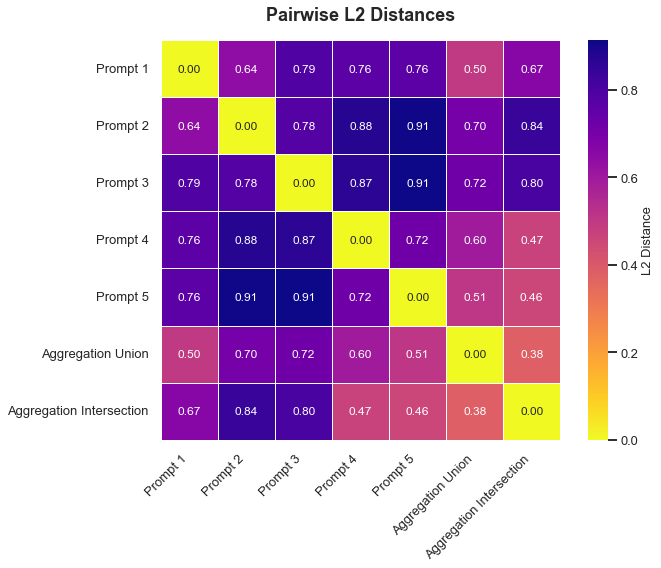

In [25]:
# Compute pairwise L2 distances
l2_distance_matrix = cdist(papers_embeddings, papers_embeddings, metric='euclidean')
l2_distance_df = pd.DataFrame(l2_distance_matrix, index=all_labels, columns=all_labels)

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    l2_distance_df,
    annot=True,
    fmt='.2f',
    cmap='plasma_r',
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'L2 Distance'},
    annot_kws={'size': 12},
    ax=ax
)

cbar = ax.collections[0].colorbar
if cbar is not None:
    cbar.set_label('L2 Distance', fontsize=13)
    cbar.ax.tick_params(labelsize=13)

ax.set_title('Pairwise L2 Distances', fontsize=18, fontweight='bold', pad=20)
ax.tick_params(labelsize=13)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Figure 2: Projection onto Top 2 Task-Specific Directions

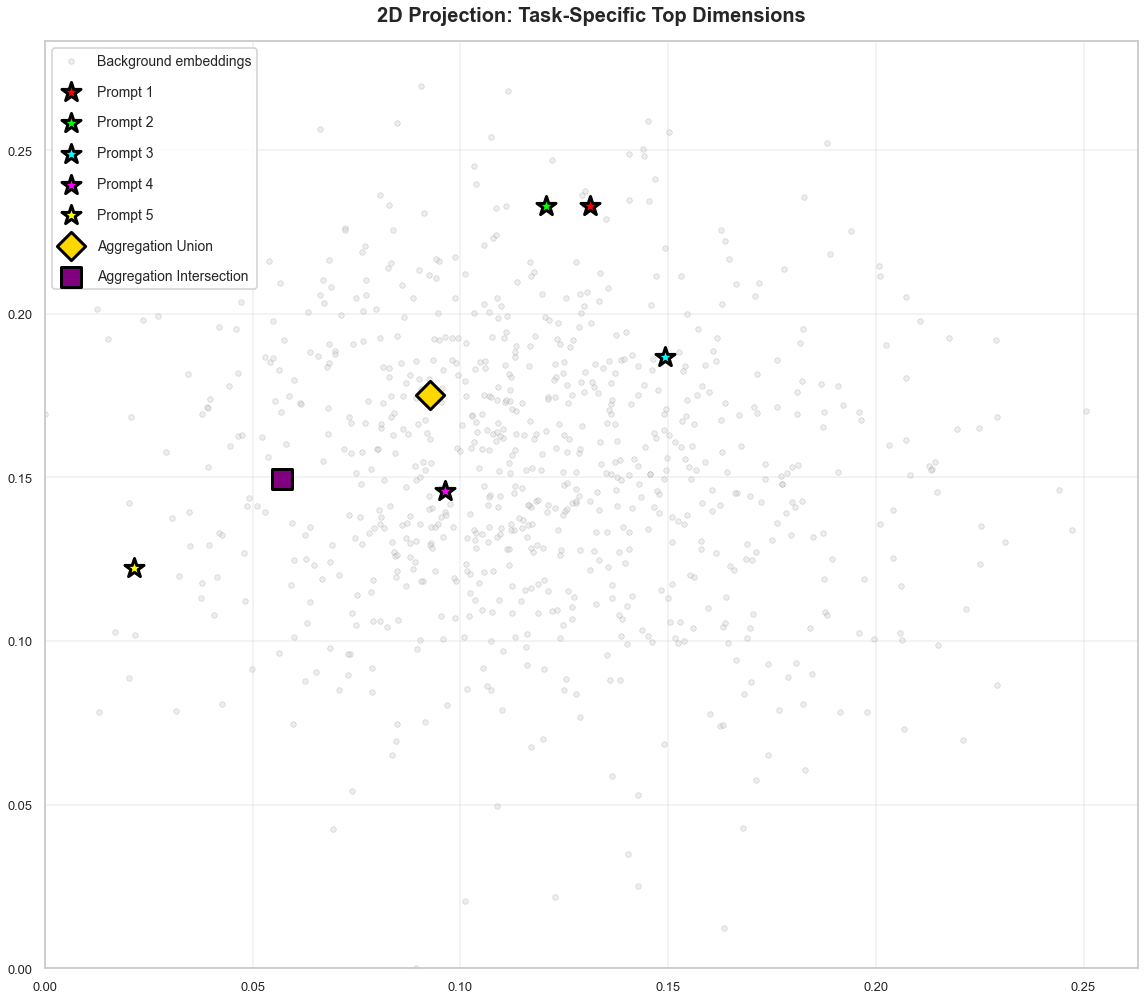

In [26]:
# Colors and markers for visualization
component_colors = ['red', 'lime', 'cyan', 'magenta', 'yellow']
aggregated_colors = ['gold', 'purple']
aggregated_markers = ['D', 's']

# Project onto top 2 task-specific dimensions
bg_proj_2d = embeddings_shifted[:, task_top_2_dims]
papers_proj_2d = papers_embeddings_shifted[:, task_top_2_dims]

fig, ax = plt.subplots(figsize=(16, 14))

# Background embeddings
ax.scatter(
    bg_proj_2d[:, 0],
    bg_proj_2d[:, 1],
    c='lightgray', alpha=0.4, s=30,
    edgecolors='gray', linewidths=0.5,
    label='Background embeddings'
)

# Component prompts
for i in range(NUM_COMPONENTS):
    ax.scatter(
        papers_proj_2d[i, 0],
        papers_proj_2d[i, 1],
        c=component_colors[i],
        s=400,
        marker='*',
        edgecolors='black',
        linewidths=3,
        label=f'Prompt {i+1}',
        zorder=10,
    )

# Aggregated outputs
for agg_idx, agg_label in enumerate(aggregated_labels):
    ax.scatter(
        papers_proj_2d[NUM_COMPONENTS + agg_idx, 0],
        papers_proj_2d[NUM_COMPONENTS + agg_idx, 1],
        c=aggregated_colors[agg_idx],
        s=400,
        marker=aggregated_markers[agg_idx],
        edgecolors='black',
        linewidths=3,
        label=agg_label,
        zorder=15,
    )

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_title('2D Projection: Task-Specific Top Dimensions', fontsize=20, fontweight='bold', pad=20)
ax.tick_params(labelsize=13)
ax.legend(loc='upper left', fontsize=14, framealpha=0.9, labelspacing=1.2)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Figure 3: Projection onto Top 3 Task-Specific Directions

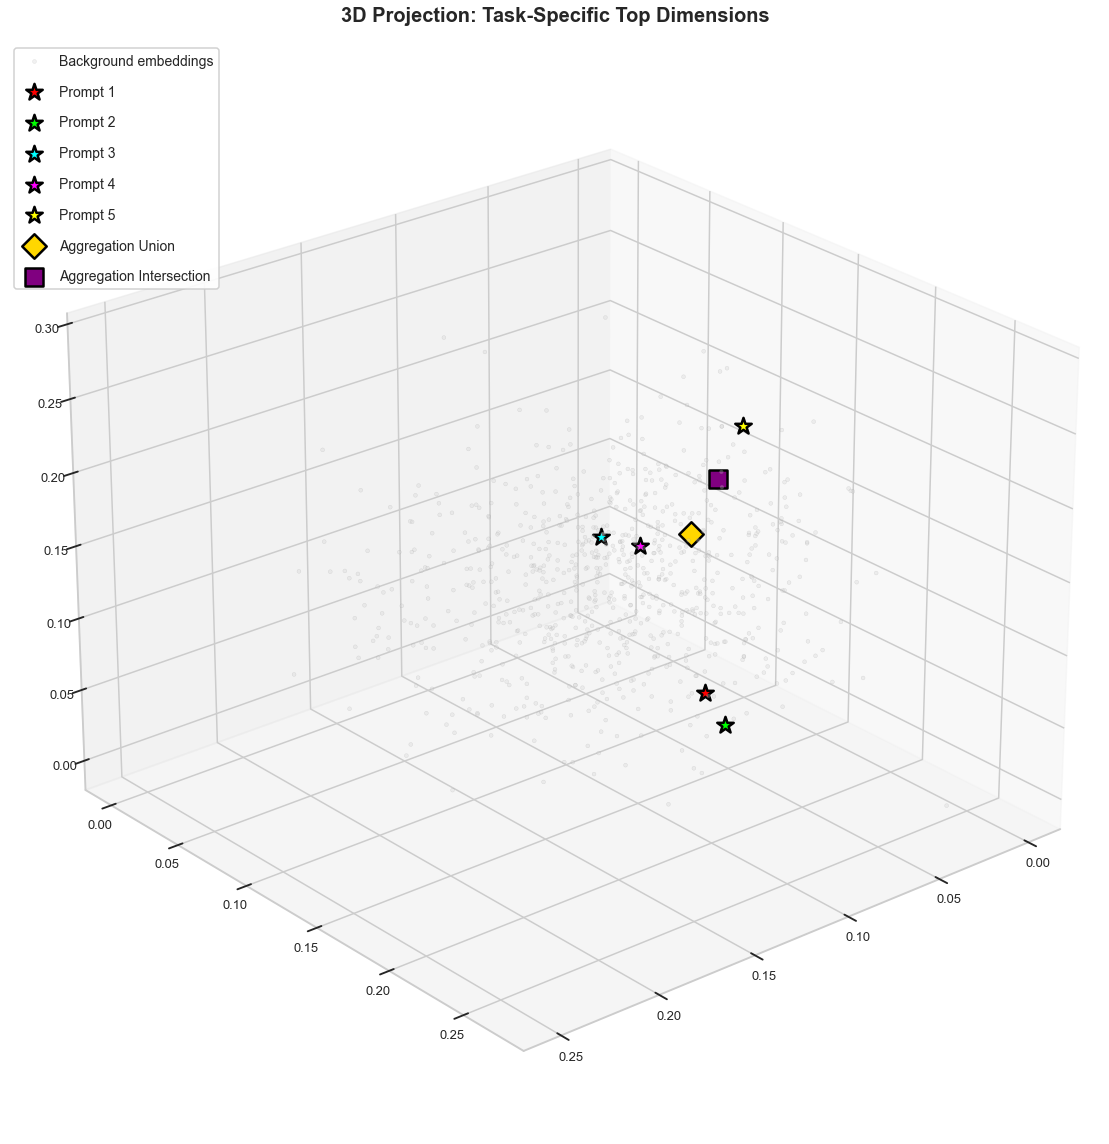

In [27]:
from mpl_toolkits.mplot3d import Axes3D

# Project onto top 3 task-specific dimensions
bg_proj_3d = embeddings_shifted[:, task_top_3_dims]
papers_proj_3d = papers_embeddings_shifted[:, task_top_3_dims]

fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection='3d')

# Background embeddings
ax.scatter(
    bg_proj_3d[:, 0],
    bg_proj_3d[:, 1],
    bg_proj_3d[:, 2],
    c='lightgray', alpha=0.3, s=15,
    edgecolors='gray', linewidths=0.3,
    label='Background embeddings'
)

# Component prompts
for i in range(NUM_COMPONENTS):
    ax.scatter(
        papers_proj_3d[i, 0],
        papers_proj_3d[i, 1],
        papers_proj_3d[i, 2],
        c=component_colors[i],
        s=300,
        marker='*',
        edgecolors='black',
        linewidths=2.5,
        label=f'Prompt {i+1}',
        zorder=10,
    )

# Aggregated outputs
for agg_idx, agg_label in enumerate(aggregated_labels):
    ax.scatter(
        papers_proj_3d[NUM_COMPONENTS + agg_idx, 0],
        papers_proj_3d[NUM_COMPONENTS + agg_idx, 1],
        papers_proj_3d[NUM_COMPONENTS + agg_idx, 2],
        c=aggregated_colors[agg_idx],
        s=300,
        marker=aggregated_markers[agg_idx],
        edgecolors='black',
        linewidths=2.5,
        label=agg_label,
        zorder=15,
    )

ax.view_init(elev=25, azim=50)
ax.set_title('3D Projection: Task-Specific Top Dimensions', fontsize=20, fontweight='bold', pad=20)
ax.tick_params(labelsize=13)
ax.legend(loc='upper left', fontsize=14, framealpha=0.9, labelspacing=1.2)
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()